# Project 3: EEG Classification Model

## Data Preprocessing

In [1]:
#1.Data Preprocessing
import os
import pandas as pd
import numpy as np
from scipy import signal
import glob  

all_data = []
all_names = []
for folder in os.listdir(r'Bonn EEG Datasets'):
    for file in glob.glob(os.path.join(r'Bonn EEG Datasets', folder, '*.txt')):
        data = np.loadtxt(file)
        all_data.append(data)
        all_names.append(folder)
all_data=np.array(all_data)


In [2]:
all_data

array([[ -73.,  -66.,  -59., ..., -113., -109.,  -93.],
       [ -31.,  -43.,  -39., ...,   -6.,   10.,   33.],
       [ -41.,  -38.,  -31., ...,    1.,  -13.,   -1.],
       ...,
       [  -4.,   33.,   65., ..., -137., -117.,  -11.],
       [  80.,   55.,   15., ...,  -74.,  -45.,  165.],
       [ -53.,  -54.,  -38., ..., -113.,  -93., -160.]])

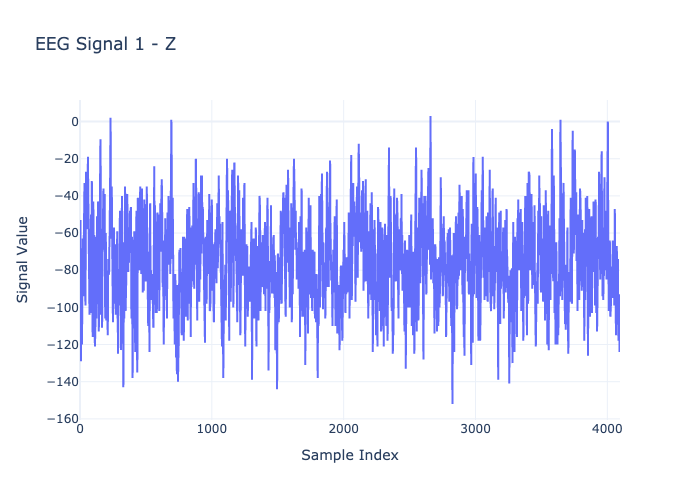

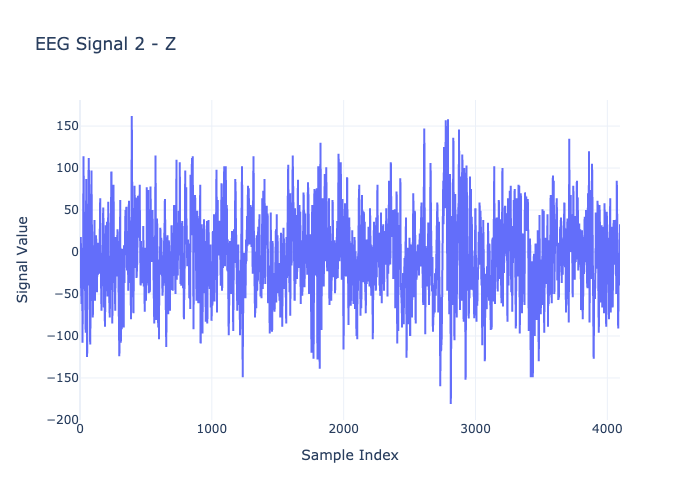

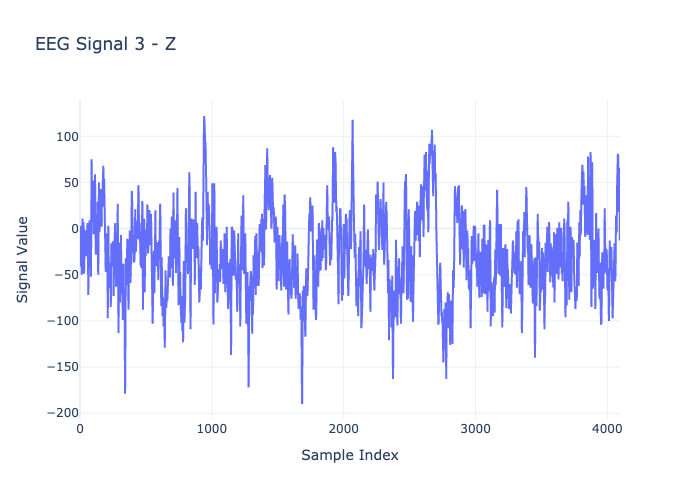

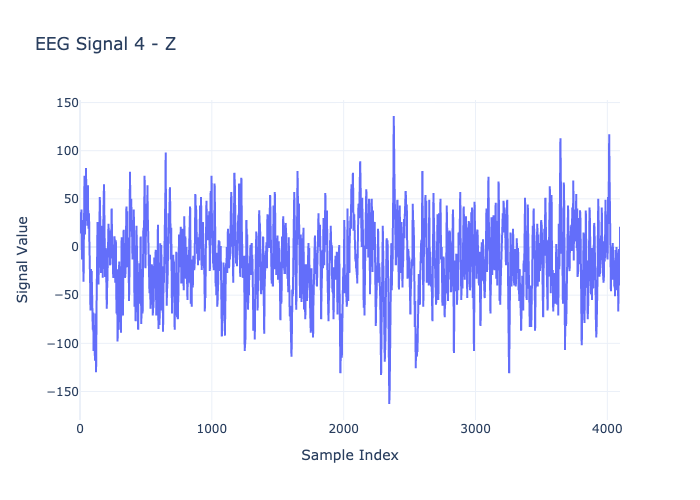

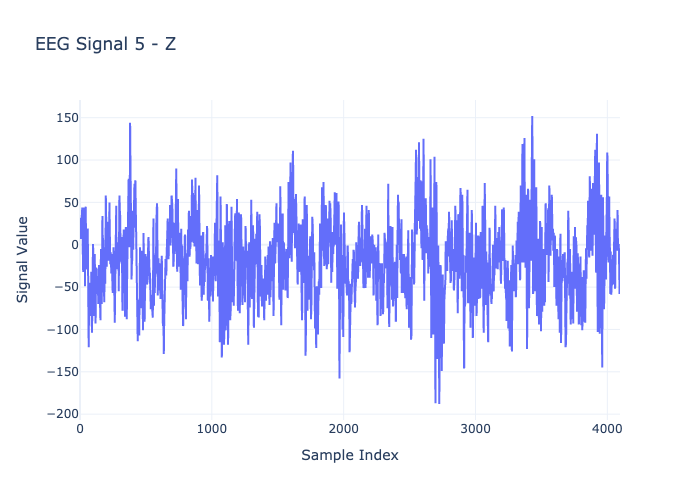

In [3]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'png' 
# Define the number of signals to plot
num_signals_to_plot = 5

# Plot each EEG signal separately using Plotly
for i in range(min(num_signals_to_plot, all_data.shape[0])):
    fig = go.Figure()
    
    # Add the EEG signal to the plot
    fig.add_trace(go.Scatter(
        y=all_data[i, :],
        mode='lines',
        name=f'EEG Signal {i + 1}'
    ))
    
    # Update the layout
    fig.update_layout(
        title=f'EEG Signal {i + 1} - {all_names[i]}',
        xaxis_title='Sample Index',
        yaxis_title='Signal Value',
        template='plotly_white',
        showlegend=False
    )
    
    # Show the figure
    fig.show()


## Check for missing value

In [4]:
#1.3 If necessary, preprocess the EEG data, including handling missing values, noise
#reduction, and data augmentation.
# Check for missing values
import numpy as np
missing_values = np.isnan(all_data).sum()
print("Missing Values:\n", missing_values)

Missing Values:
 0


In [5]:
from scipy.signal import butter, filtfilt

# Design a low-pass filter
def low_pass_filter(data, cutoff=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a,data)
    return filtered_data

# Apply the filter to the data
filtered_signal = low_pass_filter(all_data)


In [6]:
normalized_signal = (data - min(data)) / (max(data) - min(data))


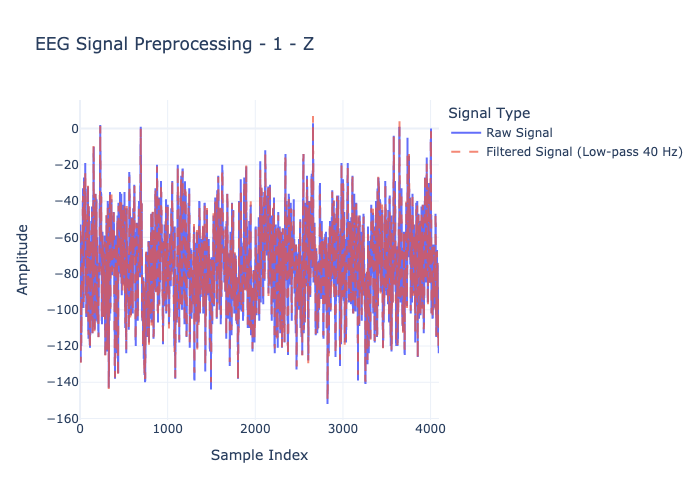

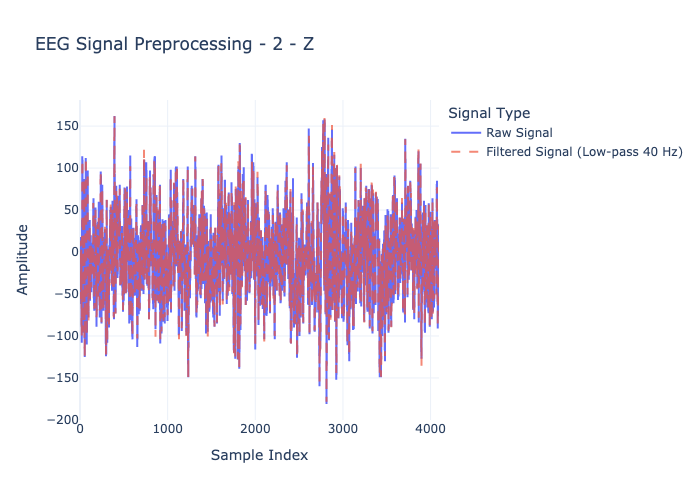

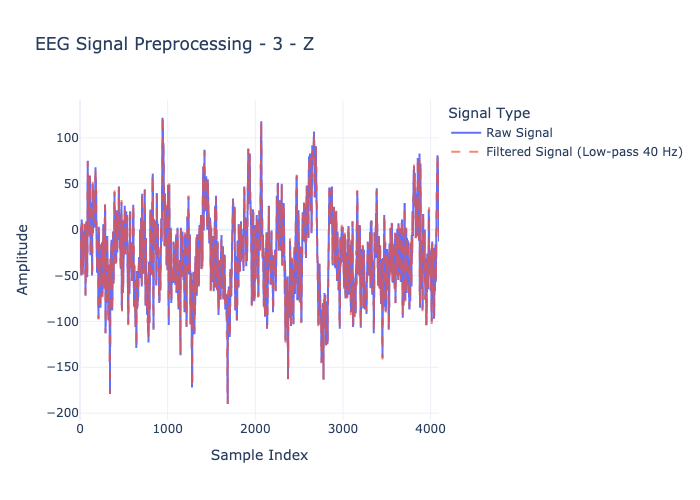

In [7]:
import plotly.graph_objects as go
 
# Define the number of signals to plot
num_samples_to_plot = 3

# Plot raw and filtered signals using Plotly
for i in range(min(num_samples_to_plot, all_data.shape[0])):
    fig = go.Figure()

    # Add raw signal
    fig.add_trace(go.Scatter(
        y=all_data[i, :],
        mode='lines',
        name='Raw Signal'
    ))
    
    # Add filtered signal
    fig.add_trace(go.Scatter(
        y=filtered_signal[i, :],
        mode='lines',
        name='Filtered Signal (Low-pass 40 Hz)',
        line=dict(dash='dash'),  # Dashed line for filtered signal
        opacity=0.7
    ))

    # Update the layout
    fig.update_layout(
        title=f'EEG Signal Preprocessing - {i + 1} - {all_names[i]}',
        xaxis_title='Sample Index',
        yaxis_title='Amplitude',
        legend_title='Signal Type',
        template='plotly_white'
    )
    
    # Show the figure
    fig.show()


Data shape: (400, 4097)
Summary statistics:
             0            1            2            3            4     \
count  400.00000   400.000000   400.000000   400.000000   400.000000   
mean    -1.08000    -8.640000   -15.927500   -18.900000   -15.972500   
std    160.39795   180.607359   208.794613   223.397731   209.540712   
min   -985.00000 -1221.000000 -1406.000000 -1395.000000 -1291.000000   
25%    -48.25000   -54.000000   -52.000000   -52.000000   -53.000000   
50%     -7.00000    -7.500000    -6.000000    -5.000000    -6.000000   
75%     43.00000    43.000000    42.250000    45.250000    45.250000   
max    800.00000   839.000000   857.000000   876.000000   893.000000   

             5           6            7            8            9     ...  \
count  400.000000  400.000000   400.000000   400.000000   400.000000  ...   
mean   -10.047500   -2.992500     2.552500     7.705000    11.127500  ...   
std    182.449595  169.319358   171.180677   171.445375   171.108259  ...  

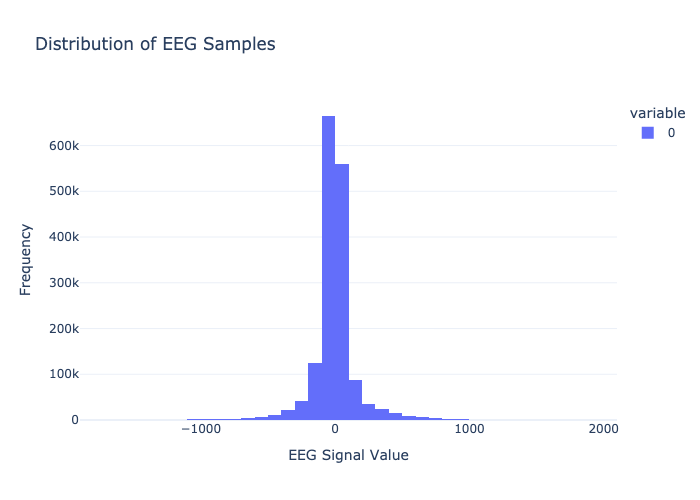

In [8]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Display basic information about the data
print("Data shape:", all_data.shape)

# Display summary statistics
summary_stats = pd.DataFrame(all_data).describe()
print("Summary statistics:\n", summary_stats)

# Check for missing values
missing_values = np.isnan(all_data).sum()
print("Missing Values:\n", missing_values)

# Visualize the distribution of EEG samples
fig = px.histogram(
    all_data.flatten(),
    nbins=50,
    title="Distribution of EEG Samples",
    labels={"value": "EEG Signal Value", "count": "Frequency"},
    template="plotly_white"
)

# Update axes labels
fig.update_layout(
    xaxis_title="EEG Signal Value",
    yaxis_title="Frequency"
)

# Show the plot
fig.show()


## Feature Exatraction

In [9]:
#2. Feature Extraction: Extract relevant features from the EEG signals. 
#Considered time-domain and frequency-domain features.
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def extract_time_domain_features(signal):
    mean_value = np.mean(signal)
    std_deviation = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    rms = np.sqrt(np.mean(np.square(signal)))
    
    return [mean_value, std_deviation, skewness, kurt, rms]

def extract_frequency_domain_features(signal, sampling_rate):
    freq, power_density = welch(signal, fs=sampling_rate, nperseg=256)
    
    # Extracting features from the power spectral density
    max_power_freq = freq[np.argmax(power_density)]
    total_power = np.sum(power_density)
    normalized_power = power_density / total_power
    
    # Calculating spectral entropy
    spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power))
    
    return [max_power_freq, spectral_entropy]


sampling_rate = 250

# Assuming all_data is 2D array of EEG signals
for i in range(all_data.shape[0]):
    signal = all_data[i, :]
    
    # Extracting time-domain features
    time_domain_features = extract_time_domain_features(signal)
    
    # Extracting frequency-domain features
    frequency_domain_features = extract_frequency_domain_features(signal, sampling_rate)
    
    # Combining features into a single feature vector
    all_features = time_domain_features + frequency_domain_features
    
    print(f"Features for EEG Signal {i + 1}: {all_features}")

Features for EEG Signal 1: [-75.10373443983403, 23.11444351197349, 0.07675374403247699, -0.0014719043738660176, 78.5802037772703, 0.9765625, 5.325660824416311]
Features for EEG Signal 2: [-3.992433487917989, 47.072316379722885, 0.06367751324413805, 0.18573236473385046, 47.24132189628246, 0.9765625, 5.356968168088765]
Features for EEG Signal 3: [-27.36953868684403, 43.70031442335459, 0.20265028735172702, 0.30725344275484634, 51.563641537722155, 0.9765625, 4.136778294992246]
Features for EEG Signal 4: [-13.600195264827923, 38.416544366905356, -0.12018981338006451, 0.2838530797533845, 40.75286728974853, 0.9765625, 4.5514699587843435]
Features for EEG Signal 5: [-17.99926775689529, 44.910957922526904, 0.14275337323253015, 0.3973123366227025, 48.38354866381126, 0.9765625, 4.637162364428122]
Features for EEG Signal 6: [1.2841103246277765, 55.89339485027922, -0.14888363338453664, 0.3331339959527231, 55.908143657387114, 0.9765625, 4.028923631685238]
Features for EEG Signal 7: [7.40639492311447

Features for EEG Signal 393: [-3.186477910666341, 60.18575008481835, 0.05594880436024939, 0.026970282197822826, 60.27004359337544, 20.5078125, 4.999482781238808]
Features for EEG Signal 394: [-4.240175738345131, 48.35797699194614, 0.045062552400909194, 0.1157707464432578, 48.543516859057945, 1.953125, 5.208818377461331]
Features for EEG Signal 395: [-5.2455455211130095, 56.96278472257302, 0.10071730975436947, 0.1611571497141897, 57.20379874767293, 1.953125, 5.034377374252937]
Features for EEG Signal 396: [-15.723456187454234, 45.47842838470547, -0.10071347787584078, 0.35634685415113054, 48.11979346195884, 13.671875, 4.554665559089591]
Features for EEG Signal 397: [-18.00951916036124, 104.21508127630374, 0.07224288114800591, -0.35067254940570436, 105.75975579498096, 16.6015625, 3.6676966136645635]
Features for EEG Signal 398: [-27.613131559677814, 54.975832472962274, 0.3102097780255876, 0.6337300042942173, 61.52094920128662, 13.671875, 4.4958263632496065]
Features for EEG Signal 399: [-

## Splitting the data

In [10]:
#3.Split the data into training, validation, and test sets:

from sklearn.model_selection import train_test_split

# Assuming labels are stored in all_names array
labels = np.array(all_names)

# Health labels: 'z' and 'o'
health_labels = np.isin(labels, ['Z', 'O'])

# Seizure labels: 'n', 'f', 's'
seizure_labels = np.isin(labels, ['N', 'F', 'S'])

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_data, health_labels, test_size=0.4, random_state=42, stratify=health_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (240, 4097)
Validation set shape: (80, 4097)
Test set shape: (80, 4097)


## Model Selection

### Objective:
- Choose a machine learning or deep learning model suited for EEG signal classification.

### Implementation:
#### Selected Convolutional Neural Networks (CNNs) because:
- CNNs are highly effective for feature extraction from time-series data, such as EEG signals.
- They automatically capture spatial and temporal dependencies in the data.
- Input EEG data was reshaped to match the input format required for CNNs (e.g., samples x time steps x channels).

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification (Healthy vs Seizure)
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the model
input_shape = (X_train.shape[1], 1)  # Assuming EEG signals are reshaped
cnn_model = create_cnn_model(input_shape)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4095, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2047, 32)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2045, 64)          6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1022, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 1020, 128)         24704     
                                                                 
 global_average_pooling1d (  (None, 128)               0


#### Input Layer:

- Accepts reshaped EEG signals.
- Example: Input(shape=(time_steps, 1)).

#### Convolutional Layers:

- Apply filters to extract features from EEG signals.
- Example: Conv1D(filters=16, kernel_size=3, activation='relu').

#### Pooling Layers:

- Reduce the spatial dimensions of the feature maps to prevent overfitting.
- Example: MaxPooling1D(pool_size=2).

#### Dropout Layers:

- Randomly drops neurons during training to prevent overfitting.
- Example: Dropout(0.5).

#### Fully Connected Layers:

- Flatten the features and connect to dense layers for final classification.
- Example: Dense(units=64, activation='relu').

#### Output Layer:

- Produces the final class probabilities using a sigmoid activation function for binary classification.

#### ########################################################

## Model Training

### Objective:
- Train the CNN model on the training dataset.

### Steps:

#### Loss Function:

- Used BinaryCrossentropy for binary classification.

#### Optimizer:

- Selected Adam optimizer for efficient gradient descent.

#### Training Process:

- Defined epochs and batch_size for training iterations.
- Incorporated callbacks like Early Stopping to halt training if validation loss stopped improving.

#### Validation:

- Evaluated model performance on the validation set after each epoch.


In [12]:
# Reshape data for CNN
X_train_reshaped = X_train.reshape(-1, X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(-1, X_val.shape[1], 1)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/30
8/8 [==============================] - 1s 69ms/step - loss: 1.9551 - accuracy: 0.5500 - val_loss: 0.7524 - val_accuracy: 0.5125
Epoch 2/30
8/8 [==============================] - 1s 63ms/step - loss: 2.0488 - accuracy: 0.5375 - val_loss: 1.2686 - val_accuracy: 0.5000
Epoch 3/30
8/8 [==============================] - 0s 63ms/step - loss: 1.0157 - accuracy: 0.5667 - val_loss: 0.5313 - val_accuracy: 0.6375
Epoch 4/30
8/8 [==============================] - 1s 76ms/step - loss: 0.9099 - accuracy: 0.5750 - val_loss: 0.9308 - val_accuracy: 0.5250
Epoch 5/30
8/8 [==============================] - 0s 58ms/step - loss: 0.7049 - accuracy: 0.5875 - val_loss: 0.6618 - val_accuracy: 0.5500
Epoch 6/30
8/8 [==============================] - 1s 77ms/step - loss: 0.6037 - accuracy: 0.6417 - val_loss: 0.5355 - val_accuracy: 0.6000
Epoch 7/30
8/8 [==============================] - 1s 69ms/step - loss: 0.5604 - accuracy: 0.6833 - val_loss: 0.5217 - val_accuracy: 0.6250
Epoch 8/30
8/8 [===========

## Model Evaluation

### Objective:
Evaluate model performance on the validation dataset and fine-tune parameters.

#### Metrics Used:
- Accuracy: Percentage of correctly classified samples.
- Precision: Proportion of true positives out of all positive predictions.
- Recall: Proportion of true positives out of all actual positives.
- F1-Score: Harmonic mean of precision and recall.

#### Implementation:
- Used classification_report and confusion_matrix to calculate metrics.
- Visualized training and validation loss/accuracy over epochs to identify overfitting or underfitting.

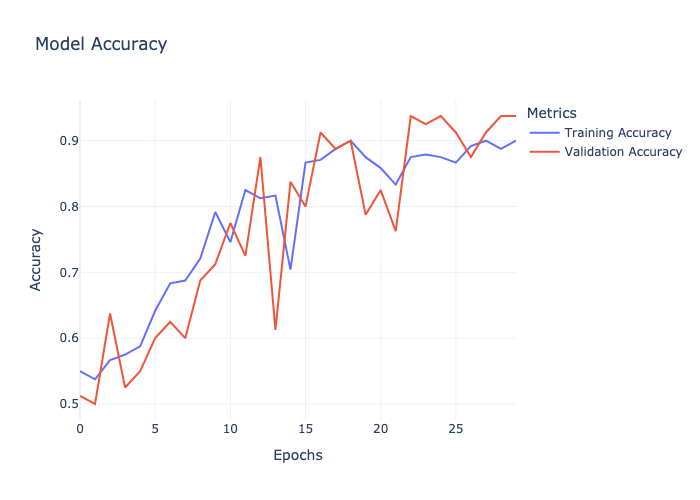

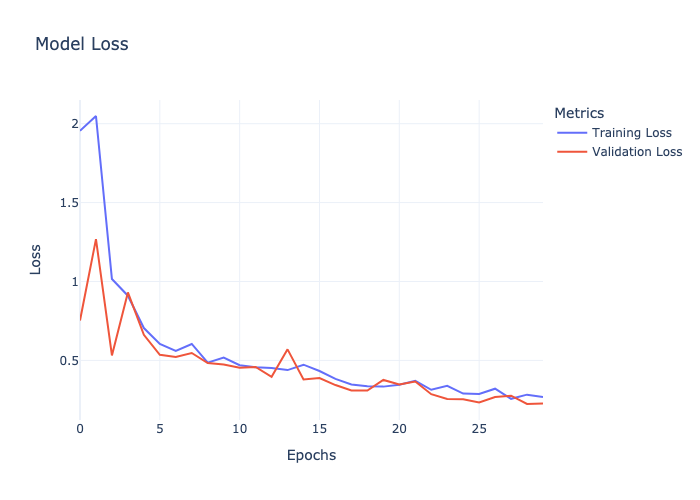

In [13]:
import plotly.graph_objects as go

# Accuracy plot
fig_accuracy = go.Figure()
fig_accuracy.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
fig_accuracy.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig_accuracy.update_layout(
    title='Model Accuracy',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    legend_title='Metrics',
    template='plotly_white'
)
fig_accuracy.show()

# Loss plot
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Training Loss'))
fig_loss.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig_loss.update_layout(
    title='Model Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend_title='Metrics',
    template='plotly_white'
)
fig_loss.show()


## Model Testing

### Objective:
Assess the generalization capability of the trained model on unseen test data.

### Steps:
#### Prepare Test Data:

- Reshaped the test set (X_test) to match the input shape of the CNN.

#### Generate Predictions:

- Applied the trained CNN to the test set.
- Converted predictions into binary classifications using a threshold (e.g., 0.5).

#### Evaluate Performance:

- Computed classification metrics (e.g., precision, recall, F1-score) on the test set.
- Analyzed the confusion matrix to understand false positives and false negatives.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Reshape the test set
X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)

# Evaluate on the test set
y_test_pred = (cnn_model.predict(X_test_reshaped) > 0.5).astype("int32")

# Generate the classification report and confusion matrix
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Test set accuracy
test_loss, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 [==============================] - 0s 15ms/step
Test Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.88      0.92        40
        True       0.89      0.97      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80

Test Confusion Matrix:
 [[35  5]
 [ 1 39]]
3/3 [==============================] - 0s 13ms/step - loss: 0.2832 - accuracy: 0.9250
Test Accuracy: 0.9250


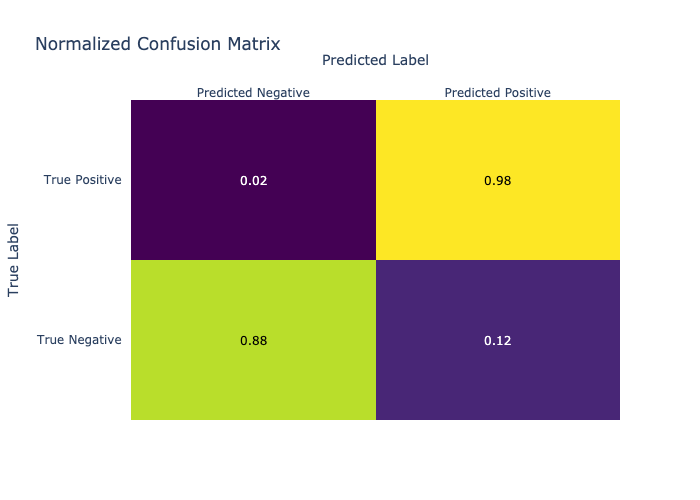

In [15]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig_cm = ff.create_annotated_heatmap(
    z=cm_normalized,
    x=['Predicted Negative', 'Predicted Positive'],  # Labels for x-axis
    y=['True Negative', 'True Positive'],  # Labels for y-axis
    annotation_text=np.round(cm_normalized, 2),  # Add text annotations
    colorscale='Viridis'
)

fig_cm.update_layout(
    title='Normalized Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    template='plotly_white'
)

fig_cm.show()


### Objective:
- Visualize the model's performance using a confusion matrix.

### Steps:
#### Generate Confusion Matrix:

- Used confusion_matrix to calculate true positives, false positives, true negatives, and false negatives.

#### Plot with Plotly:

- Created a heatmap using plotly.graph_objects to display the confusion matrix interactively.

## Summary

### Model Selection:

- CNN selected for its ability to handle time-series data like EEG signals.

### Model Training:

- Trained on features extracted from EEG signals.
- Used Early Stopping to avoid overfitting.

### Evaluation:

- Evaluated on validation data with metrics such as accuracy, precision, recall, and F1-score.

### Testing:

- Ensured generalization using the test set.
- Visualized performance with a confusion matrix.

### Interactive Visualizations:

Created intuitive, interactive graphs for better understanding of performance.
This structure ensures the model is reliable and robust for EEG signal classification tasks.